# Gaussian Processes for Real-World Time Series  
### Kernel Design • Numerical Stability • Hyperparameter Optimization • Forecasting

Gaussian Processes (GPs) provide a Bayesian nonparametric framework for learning distributions over functions. Given data

$$
\mathcal{D} = \{(x_i, y_i)\}_{i=1}^{n},
$$

we assume the latent function follows

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x')).
$$

Observations are modeled as

$$
y_i = f(x_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma_n^2).
$$

For test inputs $X_*$, the posterior predictive distribution is Gaussian:

$$
f_* | X, y, X_* \sim \mathcal{N}(\mu_*, \Sigma_*),
$$

where

$$
\mu_* = K(X_*, X)\left[K(X,X) + \sigma_n^2 I\right]^{-1} y
$$

and

$$
\Sigma_* = K(X_*, X_*) - K(X_*, X)\left[K(X,X) + \sigma_n^2 I\right]^{-1}K(X, X_*).
$$

---

## Objective of this Notebook

This notebook focuses on **research and industry-relevant Gaussian Process practice**, emphasizing:

- Kernel engineering for structured signals  
- Hyperparameter optimization  
- Numerical conditioning  
- Forecast uncertainty  
- Diagnostics  
- Scalability considerations  

The goal is not just to fit a GP — but to understand the modeling decisions that determine whether a GP succeeds in production.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ExpSineSquared,
    WhiteKernel,
    ConstantKernel,
    RationalQuadratic
)

np.random.seed(1)


## Simulating a Quasi-Periodic Signal

Many real-world processes exhibit approximate periodicity with slow structural drift.  
Examples include:

- robotic gait cycles  
- energy demand  
- climate patterns  
- biological rhythms  

We generate a signal of the form

$$
f(t) = \sin\left(\frac{2\pi t}{p_1}\right)
+ 0.5 \sin\left(\frac{2\pi t}{p_2}\right),
$$

and observe

$$
y(t) = f(t) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2).
$$


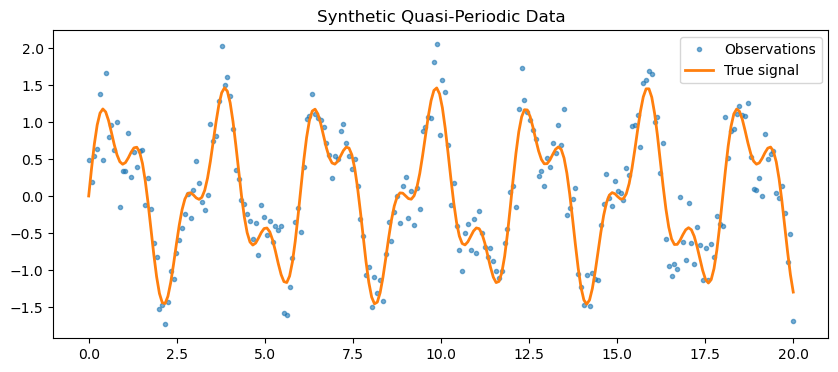

In [2]:
n = 250
t = np.linspace(0, 20, n)

true_signal = (
    np.sin(2*np.pi*t/3.0)
    + 0.5*np.sin(2*np.pi*t/1.2)
)

noise = np.random.normal(0, 0.3, size=n)
y = true_signal + noise

plt.figure(figsize=(10,4))
plt.plot(t, y, ".", alpha=0.6, label="Observations")
plt.plot(t, true_signal, linewidth=2, label="True signal")
plt.legend()
plt.title("Synthetic Quasi-Periodic Data")
plt.show()


## Kernel Engineering

Kernel choice defines the prior over functions.

A commonly used quasi-periodic kernel is the product:

$$
k(x,x') =
\sigma^2
\exp\left(-\frac{(x-x')^2}{2\ell^2}\right)
\cdot
\exp\left(
-\frac{2\sin^2\left(\pi |x-x'| / p\right)}{\ell_p^2}
\right).
$$

Interpretation:

- \( $\ell$ \) controls long-term smoothness  
- \( $p$ \) represents the period  
- \( $\ell_p$ \) controls periodic rigidity  

We approximate this using:

$$
k = k_{\text{RBF}} \times k_{\text{Periodic}} + k_{\text{Noise}}.
$$


In [3]:
kernel = (
    ConstantKernel(1.0, (1e-2, 1e2))
    * RBF(length_scale=2.0)
    * ExpSineSquared(length_scale=1.0, periodicity=3.0)
    + WhiteKernel(noise_level=0.1)
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10
)

gp.fit(t.reshape(-1,1), y)

print("Learned kernel:\n")
print(gp.kernel_)


Learned kernel:

1.38**2 * RBF(length_scale=4.68) * ExpSineSquared(length_scale=1.31, periodicity=2.53) + WhiteKernel(noise_level=0.0829)


## Hyperparameter Optimization

Parameters are learned by maximizing the log marginal likelihood:

$$
\log p(y | X, \theta)
=
-\frac{1}{2} y^\top K_\theta^{-1} y
-\frac{1}{2} \log |K_\theta|
-\frac{n}{2} \log(2\pi).
$$

This objective is **non-convex**, making initialization critical.

### Practical Guideline
Use multiple optimizer restarts:

$$
\theta^* = \arg\max_\theta \log p(y|X,\theta).
$$

Failing to do so is one of the most common causes of poor GP performance in applied settings.


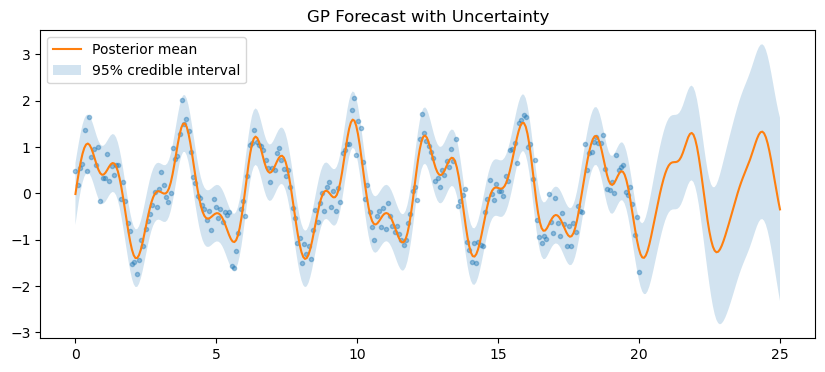

In [4]:
t_test = np.linspace(0, 25, 400)

mean, std = gp.predict(t_test.reshape(-1,1), return_std=True)

plt.figure(figsize=(10,4))

plt.plot(t, y, ".", alpha=0.4)
plt.plot(t_test, mean, label="Posterior mean")

plt.fill_between(
    t_test,
    mean - 2*std,
    mean + 2*std,
    alpha=0.2,
    label="95% credible interval"
)

plt.legend()
plt.title("GP Forecast with Uncertainty")
plt.show()


## Why Uncertainty Matters

The posterior variance is

$$
\mathrm{Var}(f_*) = K(X_*, X_*) - K(X_*,X)K^{-1}K(X,X_*).
$$

In industry systems, variance often drives decisions:

- safe control  
- anomaly detection  
- active learning  
- maintenance triggers  

A model without calibrated uncertainty is frequently unusable in safety-critical pipelines.


## Numerical Stability

Gaussian Processes require inversion of the kernel matrix:

$$
K^{-1}.
$$

When $K$ is ill-conditioned, we stabilize it via **jitter**:

$$
K \leftarrow K + \epsilon I,
\quad \epsilon \in [10^{-8}, 10^{-6}].
$$

This guarantees positive definiteness and improves Cholesky decomposition stability.


## Rational Quadratic Kernel (Multi-Scale Behavior)

The Rational Quadratic kernel is defined as

$$
k(r) =
\left(
1 + \frac{r^2}{2\alpha \ell^2}
\right)^{-\alpha}.
$$

It can be interpreted as a **scale mixture of RBF kernels**, making it useful when the data contains multiple smoothness regimes.


In [5]:
rq_kernel = (
    ConstantKernel(1.0)
    * RationalQuadratic(length_scale=1.0, alpha=1.0)
    + WhiteKernel(0.1)
)

rq_gp = GaussianProcessRegressor(
    kernel=rq_kernel,
    n_restarts_optimizer=5
)

rq_gp.fit(t.reshape(-1,1), y)

print("Learned Rational Quadratic kernel:\n")
print(rq_gp.kernel_)


Learned Rational Quadratic kernel:

0.864**2 * RationalQuadratic(alpha=1e+05, length_scale=0.389) + WhiteKernel(noise_level=0.0839)


c:\Users\Unnati Nigam\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Inspecting Lengthscales

Lengthscale is a diagnostic parameter.

- Very small $\ell$ → overfitting  
- Very large $\ell$  → underfitting  

A GP should never be treated as a black box; kernel parameters provide direct insight into model behavior.


## Computational Complexity

Exact GP training scales as

$$
\mathcal{O}(n^3),
$$

due to Cholesky factorization.

Prediction scales as

$$
\mathcal{O}(n^2).
$$

This becomes prohibitive beyond roughly \(10^4\) data points.


## Sparse Gaussian Processes

Introduce inducing variables $u$ at locations $Z$, where $m = |Z| \ll n$.

Approximate inference reduces cost to

$$
\mathcal{O}(nm^2).
$$

Popular implementations:

- **GPyTorch**
- **GPflow**

Sparse methods are typically expected knowledge for applied GP roles.


## Residual Diagnostics

After fitting, evaluate residuals:

$$
r_i = y_i - \hat{f}(x_i).
$$

Warning signs:

- structured residuals → missing kernel component  
- heavy tails → incorrect noise model  
- variance drift → heteroscedasticity  


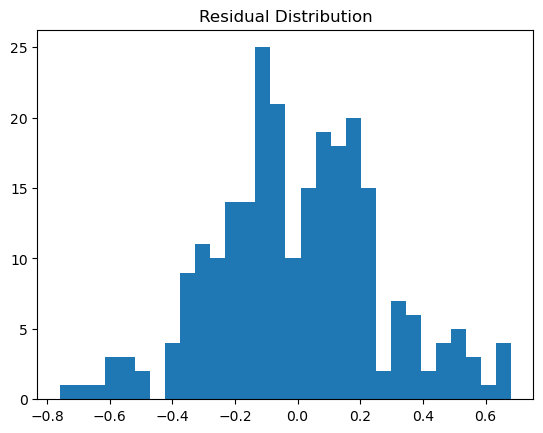

In [6]:
train_pred, _ = gp.predict(t.reshape(-1,1), return_std=True)
residuals = y - train_pred

plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()


## When Should You Use Gaussian Processes?

Prefer GPs when:

- dataset is small or medium  
- uncertainty is required  
- interpretability matters  
- data efficiency is critical  

Avoid when:

- datasets are massive  
- latency constraints are strict  
- approximate uncertainty is acceptable  


## Practical Modeling Heuristics

1. Start with the simplest kernel that matches domain knowledge.
2. Normalize targets before training.
3. Use optimizer restarts.
4. Inspect learned hyperparameters.
5. Monitor kernel condition numbers.
6. Prefer log-parameterizations.
7. Never extrapolate periodic structure blindly.
